In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
INPUT_LEN = 14
OUTPUT_LEN = 3
TOTAL_PREDICT_DAYS = 100

df_train = pd.read_csv('/content/FPT_train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])
df_train = df_train.sort_values('time').reset_index(drop=True)
df_train

,time,open,high,low,close,volume,symbol
0,2020-08-03,19.07,19.63,19.03,19.63,1392200,FPT
1,2020-08-04,19.89,20.01,19.76,19.91,1051310,FPT
2,2020-08-05,19.89,20.16,19.78,20.10,1328520,FPT
3,2020-08-06,20.10,20.21,19.97,20.01,1153660,FPT
4,2020-08-07,20.01,20.44,20.01,20.14,1283690,FPT
...,...,...,...,...,...,...,...
1144,2025-03-04,120.28,121.23,120.11,120.71,3480042,FPT
1145,2025-03-05,120.71,120.80,119.93,119.93,2862185,FPT
1146,2025-03-06,120.28,123.73,120.28,122.09,6428376,FPT
1147,2025-03-07,122.18,123.04,121.66,121.92,2966941,FPT


In [17]:
# create log transform
df_train['close_log'] = np.log(df_train['close'])

print(f'Train data shape: {df_train.shape}')
print(f'Data range: {df_train['time'].min()} to {df_train['time'].max()}')
print(df_train[['time', 'close', 'close_log']].head())

Train data shape: (1149, 8)
Data range: 2020-08-03 00:00:00 to 2025-03-10 00:00:00
        time  close  close_log
0 2020-08-03  19.63   2.977059
1 2020-08-04  19.91   2.991222
2 2020-08-05  20.10   3.000720
3 2020-08-06  20.01   2.996232
4 2020-08-07  20.14   3.002708


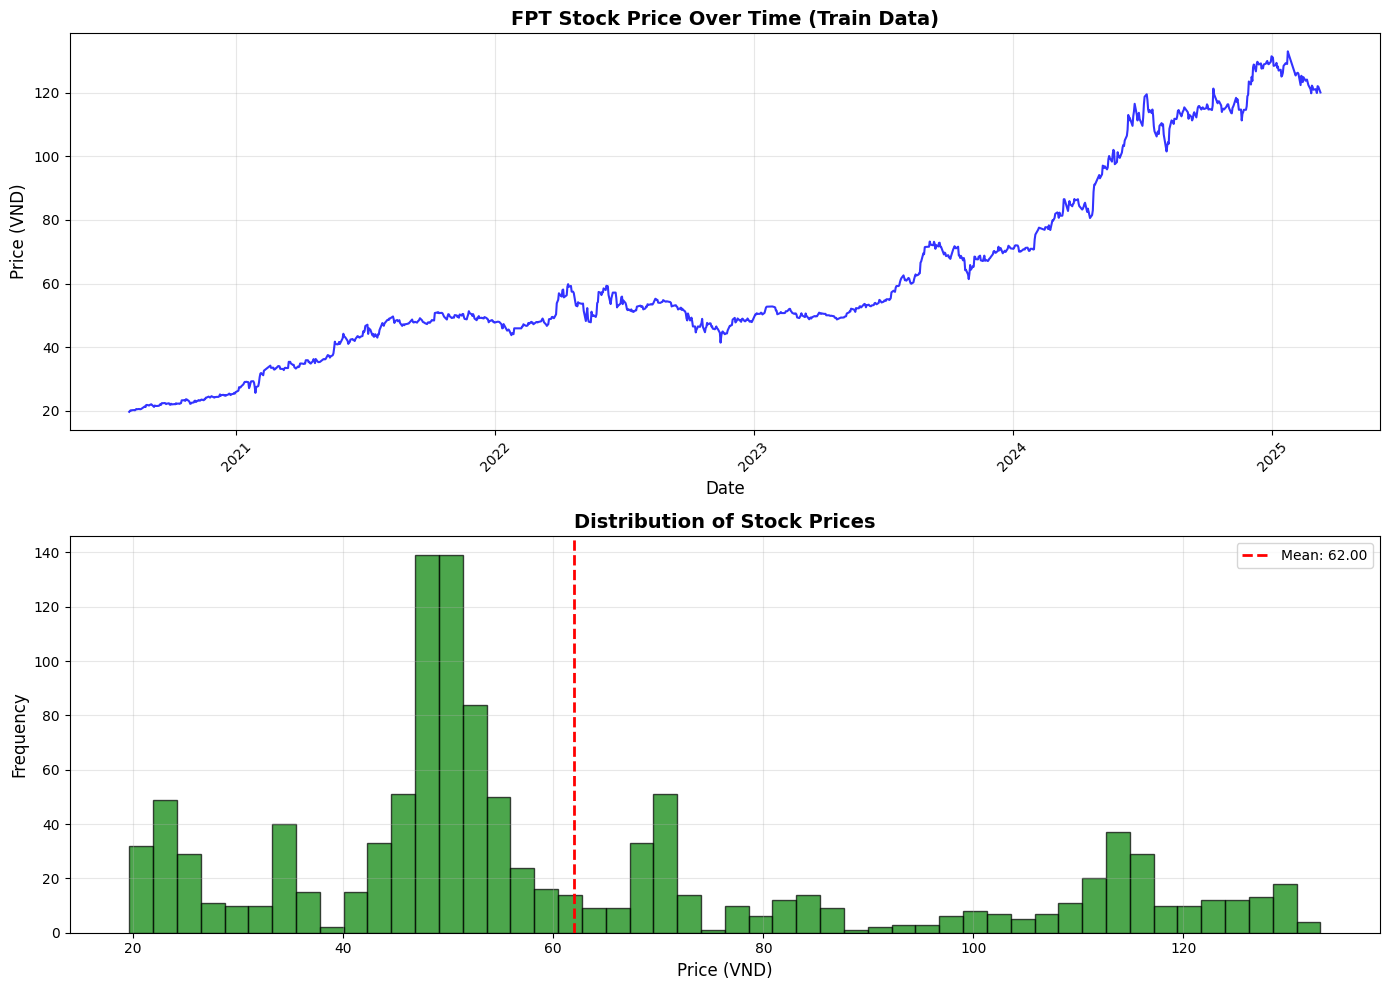

In [18]:
# Data Analysis
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Stock price over time
axes[0].plot(df_train['time'], df_train['close'], linewidth=1.5, color='blue', alpha=0.8)
axes[0].set_title('FPT Stock Price Over Time (Train Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Price distribution
axes[1].hist(df_train['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Stock Prices', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (VND)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(df_train['close'].mean(),
                color='red',
                linestyle='--',
                linewidth=2,
                label=f'Mean: {df_train['close'].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
class TimeSeriesDatasetMulti(Dataset):
    def __init__(self, data, input_len, output_len,
                 target_col='close_log',
                 feature_cols=None):
        if feature_cols is None:
            feature_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

        self.feature_cols = feature_cols
        self.target_col = target_col
        self.input_len = input_len
        self.output_len = output_len

        self.features = data[feature_cols].values.astype('float32')   # [N, F]
        self.target = data[target_col].values.astype('float32')      # [N]
        self.target_idx = feature_cols.index(target_col)

    def __len__(self):
        return len(self.target) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.input_len]  # [L, F]
        y = self.target[idx + self.input_len : idx + self.input_len + self.output_len]
        return torch.from_numpy(x), torch.from_numpy(y)

feature_cols = ['open', 'high', 'low', 'close', 'volume', 'close_log']
dataset = TimeSeriesDatasetMulti(df_train, INPUT_LEN, OUTPUT_LEN,
                                 target_col='close_log',
                                 feature_cols=feature_cols)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
enc_in = len(feature_cols)
target_idx = dataset.target_idx

print(f'Dataset size: {len(dataset)} samples')
print(f'Sample shape: input={INPUT_LEN}, output={OUTPUT_LEN}')

Dataset size: 1133 samples
Sample shape: input=14, output=3


In [20]:
class NLinear(nn.Module):
    def __init__(self, seq_len, pred_len, enc_in):
        super(NLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [B, L, C]
        x = x.permute(0, 2, 1)         # [B, C, L]
        seq_last = x[:, :, -1:].detach()
        x = x - seq_last
        out = self.Linear(x)           # [B, C, pred_len]
        out = out + seq_last
        out = out.permute(0, 2, 1)     # [B, pred_len, C]
        return out

model = NLinear(INPUT_LEN, OUTPUT_LEN, enc_in).to(device)

In [21]:
# Training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)           # [B, L, C]
        batch_y = batch_y.to(device)           # [B, pred_len]

        optimizer.zero_grad()
        outputs = model(batch_x)               # [B, pred_len, C]
        pred_close_log = outputs[:, :, target_idx]   # [B, pred_len]

        loss = criterion(pred_close_log, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

print("Training finished.")


Epoch [5/30], Loss: 0.007639
Epoch [10/30], Loss: 0.001292
Epoch [15/30], Loss: 0.000633
Epoch [20/30], Loss: 0.000607
Epoch [25/30], Loss: 0.000573
Epoch [30/30], Loss: 0.000568
Training finished.


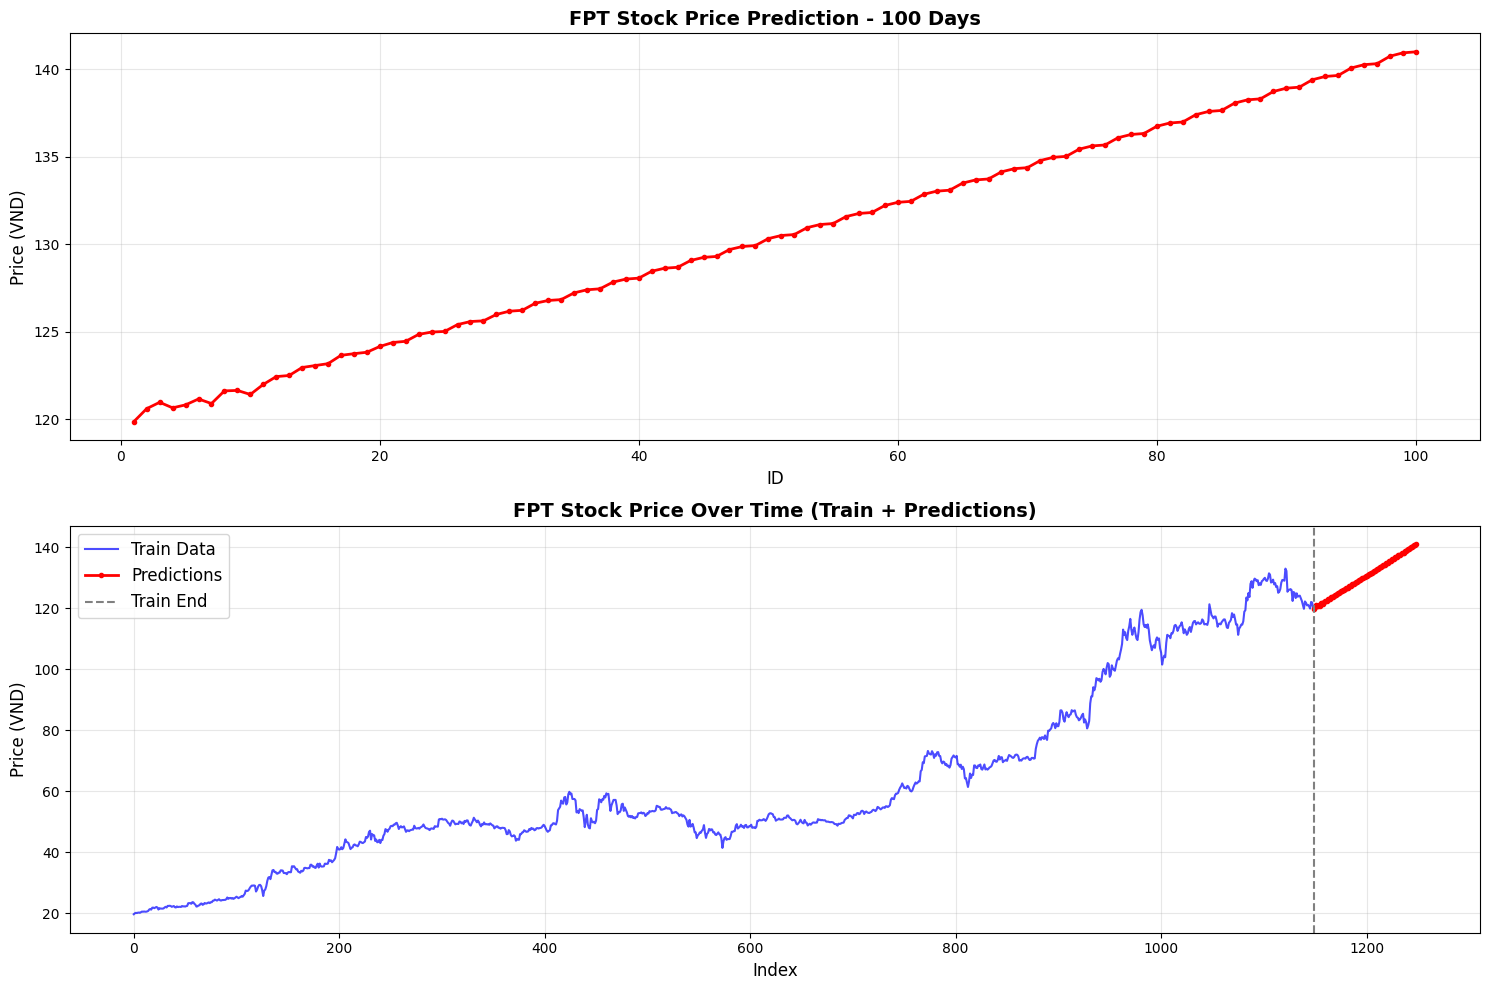

In [22]:
# take the last 14 days of all features
initial_input = df_train[feature_cols].values[-INPUT_LEN:].astype('float32')  # [14, C]
current_input = initial_input.copy()

model.eval()
all_predictions_log = []

with torch.no_grad():
    remaining_days = TOTAL_PREDICT_DAYS

    while remaining_days > 0:
        predict_this_step = min(OUTPUT_LEN, remaining_days)

        input_tensor = torch.from_numpy(current_input).unsqueeze(0).to(device)  # [1, L, C]
        output = model(input_tensor)                                            # [1, pred_len, C]

        pred_close_log = output[0, :predict_this_step, target_idx].cpu().numpy()
        all_predictions_log.extend(pred_close_log)

        # create new feature: copy features from the last day
        last_feat = current_input[-1].copy()                        # [C]
        new_steps = np.tile(last_feat, (predict_this_step, 1))     # [pred_this_step, C]
        new_steps[:, target_idx] = pred_close_log                  # update close_log

        # delete OUTPUT_LEN of first day, add prediction
        current_input = np.concatenate(
            [current_input[OUTPUT_LEN:], new_steps],
            axis=0
        )

        remaining_days -= predict_this_step

# transform log to closing price
predictions_close = np.exp(all_predictions_log)

prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))

# visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# plot 1: predict next 100 days
axes[0].plot(prediction_ids, predictions_close, linewidth=2.0, color='red', marker='o', markersize=3)
axes[0].set_title(f'FPT Stock Price Prediction - {TOTAL_PREDICT_DAYS} Days', fontsize=14, fontweight='bold')
axes[0].set_xlabel('ID', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: combine train data và predictions
last_train_idx = len(df_train)
axes[1].plot(range(len(df_train)), df_train['close'], linewidth=1.5, color='blue', alpha=0.7, label='Train Data')
axes[1].plot(range(last_train_idx, last_train_idx + TOTAL_PREDICT_DAYS), predictions_close, linewidth=2, color='red', marker='o',
             markersize=3, label='Predictions')
axes[1].axvline(last_train_idx, color='gray', linestyle='--', linewidth=1.5, label='Train End')
axes[1].set_title('FPT Stock Price Over Time (Train + Predictions)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index', fontsize=12)
axes[1].set_ylabel('Price (VND)', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()